## Baseball Stats

In [1]:
import os
import sqlite3 as sql
import logging

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from scrapers import fangraph
import bb_stat_utils

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', level=logging.INFO)
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# Point to the SQLLTIE Db
db_path = r'/home/zach/dev/demos/2021_Baseball_PURE.db'
if not os.path.exists(db_path):
    #This may take a while (~30 mins)
    fangraphscraper = fangraph.FangraphScraper(db_path)
    fangraphscraper.generate_sqllite_tables()
conn = sql.connect(db_path)

In [5]:
df = pd.read_sql('SELECT BO, RBI, PA FROM BAT WHERE "POS"!="P" AND "POS"!="PH" AND PA!=0', con = conn)
df = df.astype(int)

In [ ]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxenplot(data=df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

In [ ]:
# KS Test For Normality
for i in np.arange(1000, 10000, 1000):
    rvs = stats.norm.rvs(size=i)
    f = stats.kstest(rvs, "norm")
    print(i, f.pvalue)

In [ ]:
# LOOKS PROMSING
dist_df = df[['PA', 'BO']].groupby('BO').describe()
idx = pd.IndexSlice
x = np.random.normal(*dist_df.loc[:, idx['PA', ['mean', 'std']]].values.T,size=(10000,9))
cont_df = pd.DataFrame(x,columns=range(1,10))
flat_cont_df = cont_df.melt(var_name='BO',value_name='PA')

In [ ]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=flat_cont_df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(flat_cont_df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/home/zach/dev/demos/.env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7160: RuntimeWarning:

1 Power_divergenceResult(statistic=nan, pvalue=nan)
2 Power_divergenceResult(statistic=nan, pvalue=nan)
3 Power_divergenceResult(statistic=nan, pvalue=nan)
4 Power_divergenceResult(statistic=nan, pvalue=nan)
5 Power_divergenceResult(statistic=nan, pvalue=nan)
6 Power_divergenceResult(statistic=nan, pvalue=nan)
7 Power_divergenceResult(statistic=nan, pvalue=nan)
8 Power_divergenceResult(statistic=nan, pvalue=nan)
9 Power_divergenceResult(statistic=nan, pvalue=nan)


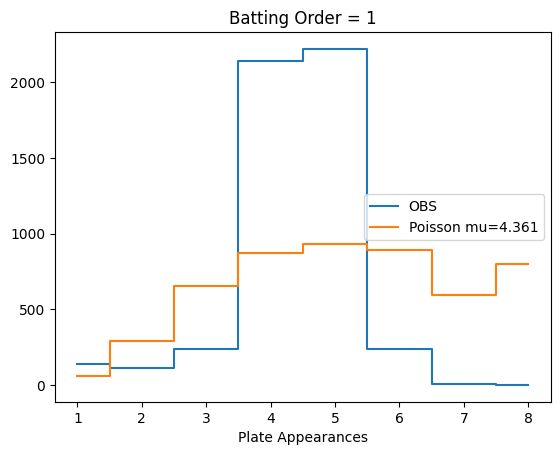

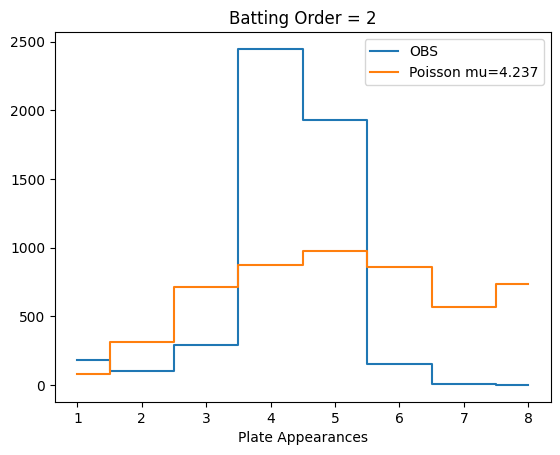

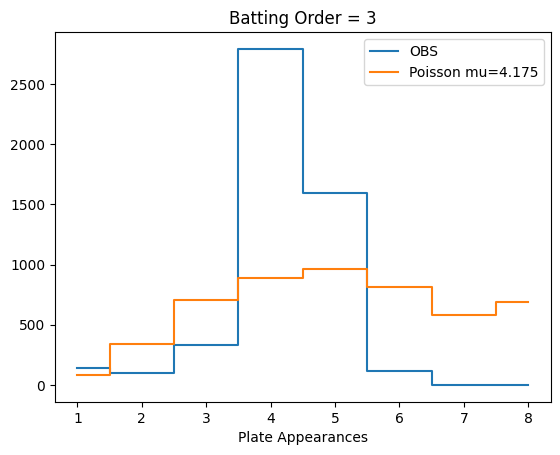

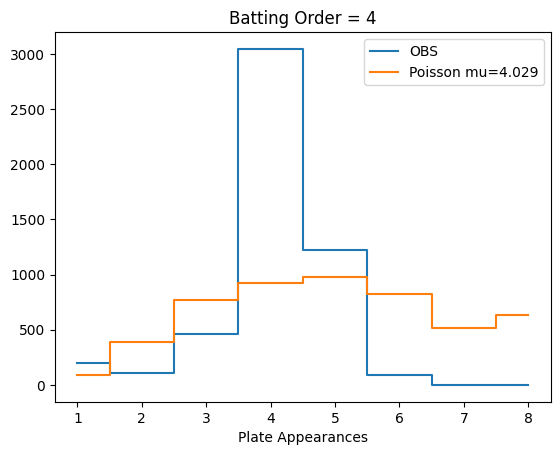

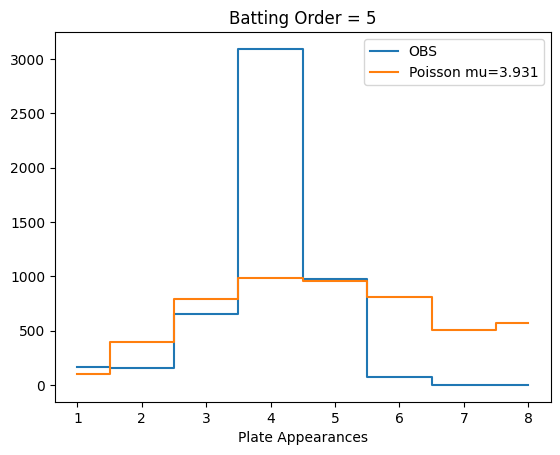

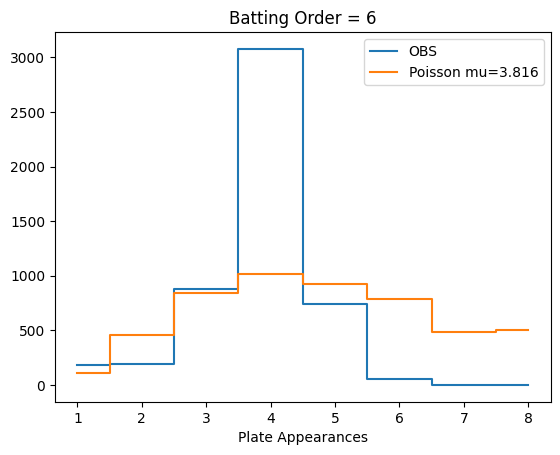

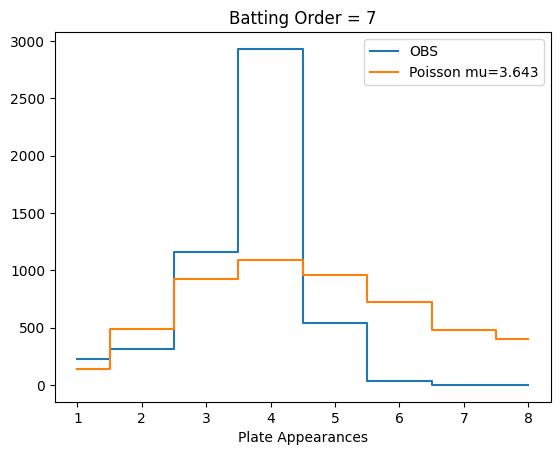

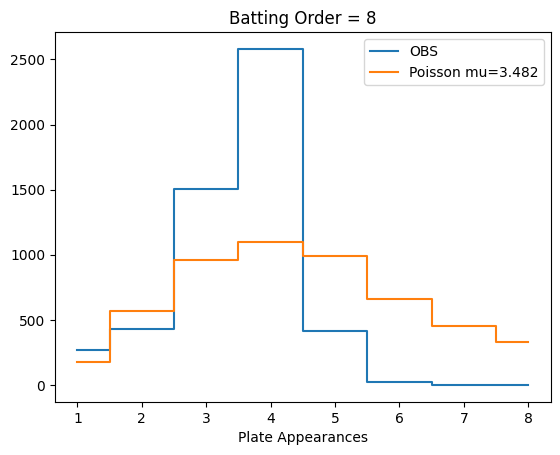

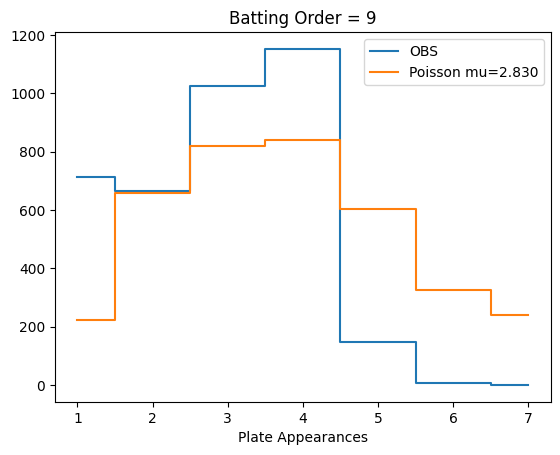

In [9]:
# POISON DOESNT MODEL IT WELL
# https://bookdown.org/yg484/rec_4_note/chi-square-goodness-of-fit-test.html
dfg_obs_counts = df.groupby(['BO'])['PA'].value_counts() 
dfg_obs_mean = df.groupby(['BO'])['PA'].mean() 
idx = pd.IndexSlice

for i in range(1, 10): 

    dfc = dfg_obs_counts.loc[idx[i,:]].sort_index()
    obs_index = dfc.index.values
    above_max_pa = obs_index[-1] + 1
    dfc[above_max_pa] = 0
    obs_index = dfc.index.values
    
    # Sample a Poisson Distro as Defined by Sample Mean (Mu)
    # Adding an Additional state of n or PA
    mu = dfg_obs_mean.loc[i]
    rvs = stats.poisson.rvs(dfg_obs_mean.loc[i], loc=1, size=sum(dfc), random_state=1)
    rv_df = pd.value_counts(rvs)
    exp_above = rv_df[range(obs_index[-1], len(rv_df)+1)].sum()
    rv_df = rv_df[obs_index]
    rv_df[above_max_pa] = exp_above

    # Goodness of Fit
    f = stats.chisquare(f_obs=dfc.values, f_exp=rv_df.values)
    
    print(i, f)
    
    plt.figure()
    plt.title(f'Batting Order = {i}')
    plt.step(obs_index, dfc.values, where='mid', label='OBS')
    plt.step(obs_index, rv_df.values, where='mid', label=f'Poisson mu={mu:2.3f}')
    plt.xlabel('Plate Appearances')
    plt.legend()